In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

In [ ]:
!pip install blobfile

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR
from torch.utils.data import DataLoader
import pickle
from tokenizer import Tokenizer_iwslt_ende, Tokenizer_wmt_ende
import time
import random
from tqdm import tqdm

from utils.config import Config
from utils.utils_func_d import *
from utils.utils_data import DLoader_wmt, DLoader_iwslt
from models.model_dnn_c import Transformer as TransformerNMT#dn for original, d for ring

#from torch.utils.data.distributed import DistributedSampler as DDS
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel.distributed import DistributedDataParallel as DDP
#import torch.utils.data.distributed.DistributedDataParallel as DDP
import dist_util
from accelerate import Accelerator
from accelerate import DistributedDataParallelKwargs
import logging
import transformers

from utils_s.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
import os

In [ ]:
import json

class Config:
    def __init__(self, path):
        self.path = path
        with open(self.path, 'r') as f:
            data = json.load(f)
            self.__dict__.update(data)


    @property
    def dict(self):
        return self.__dict__

In [ ]:
device = 'gpu'
mode = 'train'
cont = 0
name = ''

In [ ]:
config = Config('config.json')
base_path = config.base_path
data_type = config.data_type

In [ ]:

config.dataset_path = make_dataset_path(base_path, data_type)

In [ ]:
config.loss_data_path = base_path + 'loss/' + config.loss_data_name + '.pkl'

In [ ]:
model_folder = base_path + 'model/' + config.model_name
config.model_path = model_folder + '/' + config.model_name + '.pt'
model_json_path = model_folder + '/' + config.model_name + '.json'

In [ ]:
base_path = config.base_path
model_path = config.model_path
data_path = config.dataset_path

# train params
batch_size = config.batch_size
epochs = config.epochs
lr = config.lr
max_len = config.max_len
result_num = config.result_num

# define tokenizer (WMT uses shared tokenizer)
src_tokenizer = Tokenizer_wmt_ende()
trg_tokenizer = Tokenizer_wmt_ende()
tokenizers = [src_tokenizer, trg_tokenizer]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [ ]:
dataset = {s: DLoader_wmt(load_dataset(p), tokenizers, config) for s, p in data_path.items() if s == 'test'}
dataloaders = {s: DataLoader(d, 64, shuffle=False, num_workers=4) for s, d in dataset.items() if s == 'test'}

In [ ]:
from models.model_OWF_block import Transformer as TransformerNMTo#Ro08_wocc
from models.model_Ring_block import Transformer as TransformerNMTr
from models.model_universal_block import Transformer as TransformerNMTu
from models.model_vanilla_block import Transformer as TransformerNMTv

In [ ]:
model_v = TransformerNMTv(config, tokenizers)
model_r = TransformerNMTr(config, tokenizers)
model_o = TransformerNMTo(config, tokenizers)
model_u = TransformerNMTu(config, tokenizers)

In [ ]:
model_v.load_state_dict(torch.load('checkpoint_b_van_01.pt', map_location=torch.device('cpu')), strict=False)#, map_location=torch.device('cpu')

<ipython-input-67-423f01d143ac>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_v.load_state_dict(torch.load('checkpoint_b_van_01.pt', map_location=torch.device('cpu'

<All keys matched successfully>

In [ ]:
model_r.load_state_dict(torch.load('checkpoint_b_Ro08_woc_c.pt', map_location=torch.device('cpu')), strict=False)#, map_location=torch.device('cpu')

<ipython-input-68-d17a4076324a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_r.load_state_dict(torch.load('checkpoint_b_Ro08_woc_c.pt', map_location=torch.device('

<All keys matched successfully>

In [ ]:
model_o.load_state_dict(torch.load('checkpoint_b_owfT_all.pt', map_location=torch.device('cpu')), strict=False)#, map_location=torch.device('cpu')

<ipython-input-69-d2963223683e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_o.load_state_dict(torch.load('checkpoint_b_owfT_all.pt', map_location=torch.device('cp

<All keys matched successfully>

In [ ]:
model_u.load_state_dict(torch.load('checkpoint_b_uni_c.pt', map_location=torch.device('cpu')), strict=False)#, map_location=torch.device('cpu')

<ipython-input-70-0d55bd3f257b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_u.load_state_dict(torch.load('checkpoint_b_uni_c.pt', map_location=torch.device('cpu')

<All keys matched successfully>

In [ ]:
from centeredkernelalignment.cka import CKA

In [ ]:
import inspect
from collections.abc import Callable
from functools import partial
from typing import Any
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
from transformers import PreTrainedModel

from centeredkernelalignment.cka.core import cka_batch

In [ ]:
layers = []
for i in range(6):
  layers.append('decoder.Idens.'+str(i))

layers

['decoder.Idens.0',
 'decoder.Idens.1',
 'decoder.Idens.2',
 'decoder.Idens.3',
 'decoder.Idens.4',
 'decoder.Idens.5']

In [ ]:
from centeredkernelalignment.cka import CKA

In [ ]:
cka_model = CKA(
        first_model=model_v,
        second_model=model_r,
        layers=layers,
        first_name="Vanilla Transformer",
        second_name="RingFormer",#One Wide, Ring, Universal
        use_hooks=True,
        device="cuda:0",#cuda:0
    )


In [ ]:
cka_matrix_diff = cka_model(dataloaders['test'], epochs=1)

/content/drive/MyDrive/Test_ring_de_07/src/centeredkernelalignment/cka/cka.py:215: UserWarning: We suggest setting 'shuffle=True' in your dataloader in order to have a less biased computation.
  warn("We suggest setting 'shuffle=True' in your dataloader in order to have a less biased computation.")
| Computing CKA |:   0%|          | 0/1 [00:00<?, ?it/s]
| Computing CKA epoch 0 |:   0%|          | 0/47 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

| Computing CKA epoch 0 |:   2%|▏         | 1/47 [00:01<01:04,  1.41s/it]
| Computing CKA epoch 0 |:   4%|▍         | 2/47

In [ ]:
# Plot the CKA values
plot_parameters = {
    # "show_ticks_labels": True,
    # "short_tick_labels_splits": 4,
    "use_tight_layout": True,
    "show_half_heatmap": True,
}

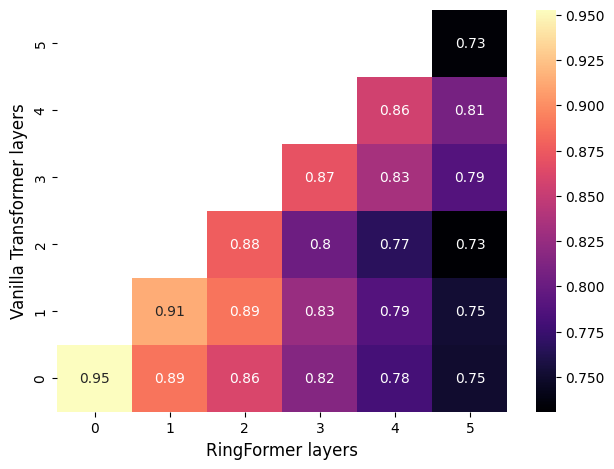

In [ ]:
#van_ring_enc
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

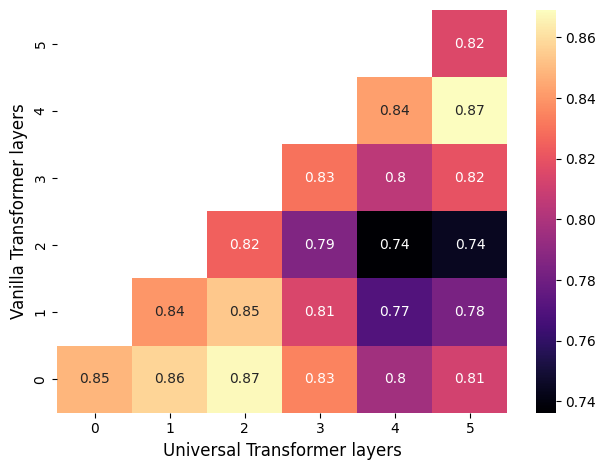

In [ ]:
#van_uni_enc
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

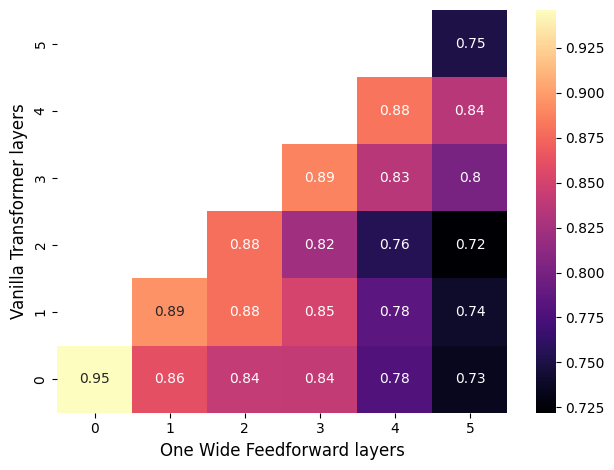

In [ ]:
#van_owf_enc
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

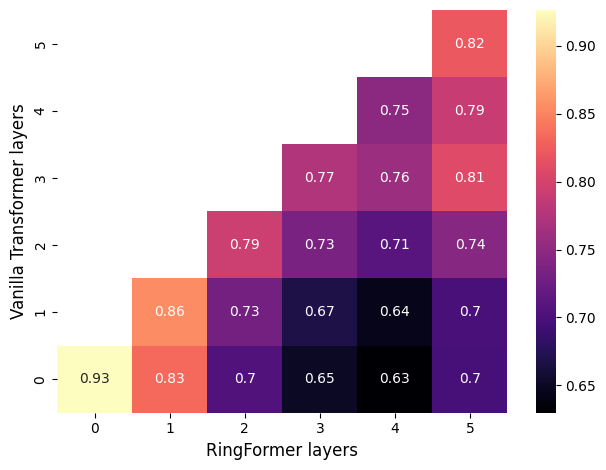

In [ ]:
#van_ring_dec
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

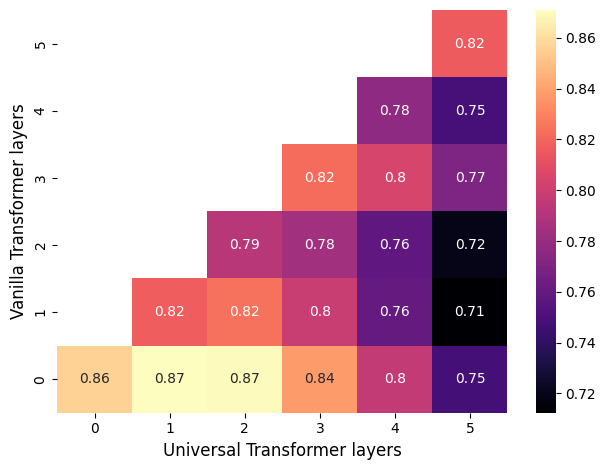

In [ ]:
#van_uni_dec
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

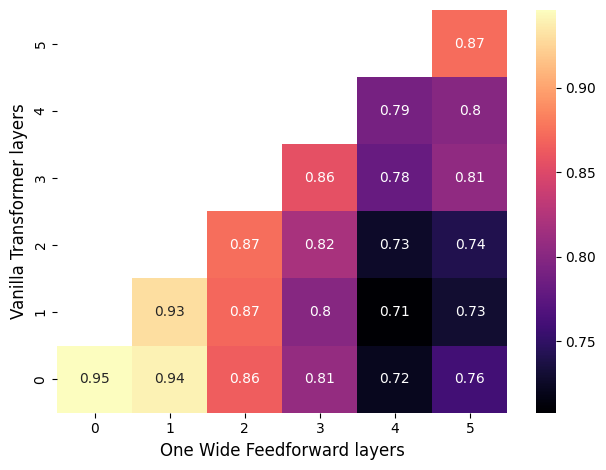

In [ ]:
#van_owf_dec
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

In [ ]:
#############base sizes

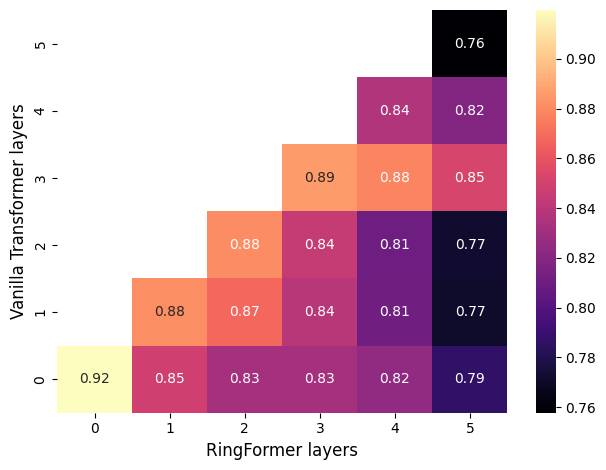

In [ ]:
#van_ring_enc
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

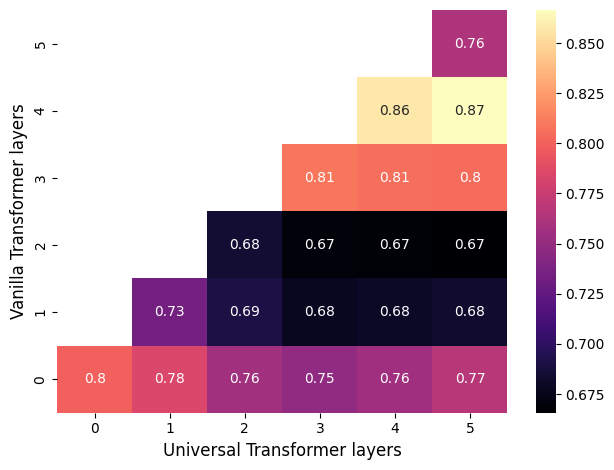

In [ ]:
#van_uni_enc
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

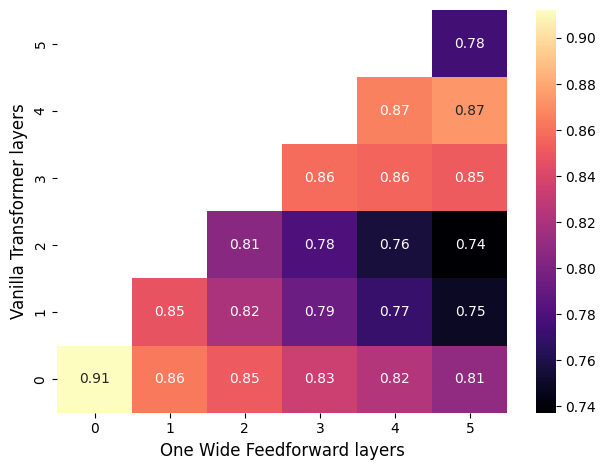

In [ ]:
#van_owf_enc
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

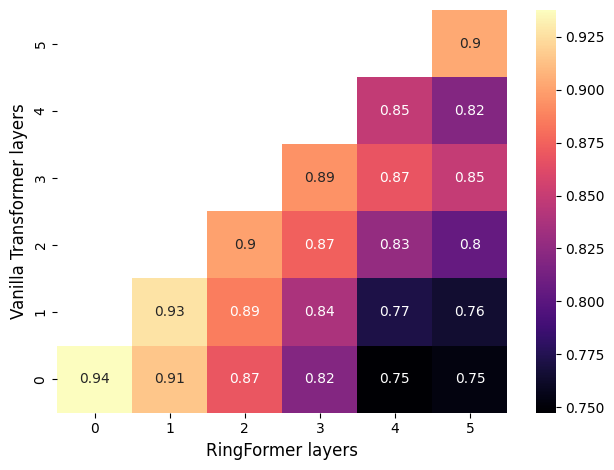

In [ ]:
#van_ring_dec
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

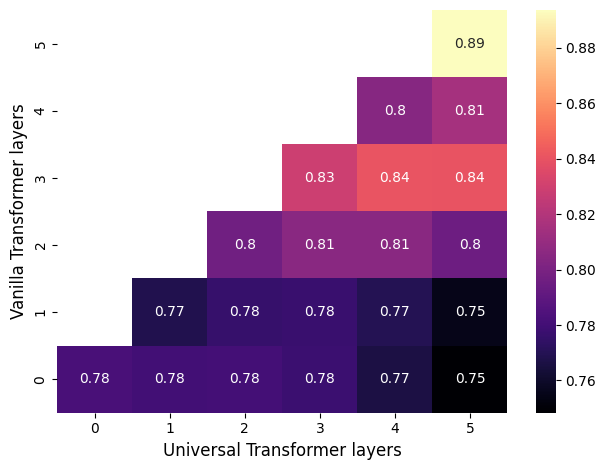

In [ ]:
#van_uni_dec
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )

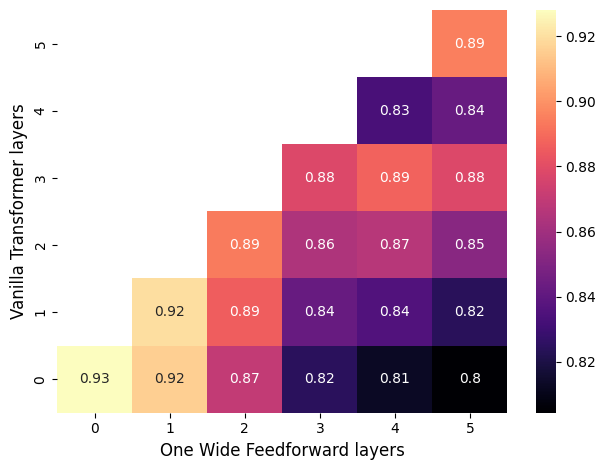

In [ ]:
#van_owf_dec
cka_model.plot_cka(
        cka_matrix=cka_matrix_diff,
        title=f"", #"Model {cka_same_model.second_model_infos['name']} compared with vanilla",
        **plot_parameters,
    )